7000.0


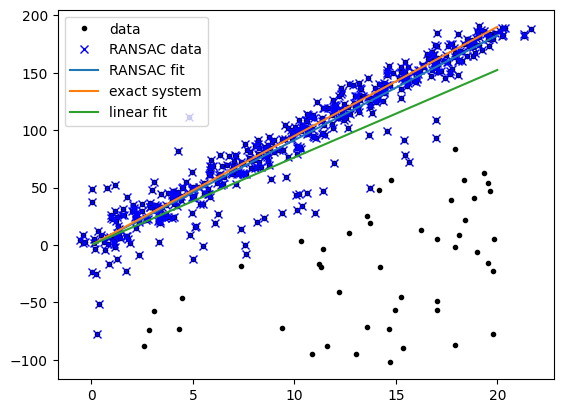

In [1]:
import numpy as np
import scipy as sp
import scipy.linalg as sl

def ransac(data,model, n, k, t, d, debug=False, return_all = False):
    print(t)
    iterations = 0
    bestfit = None
    besterr = np.inf
    best_inlier_idxs = None
    while iterations < k:
        maybe_idxs, test_idxs = random_partition(n, data.shape[0])
        # print('test_idxs = ', test_idxs)
        maybe_inliers = data[maybe_idxs,:]
        test_point = data[test_idxs]
        maybemodel = model.fit(maybe_inliers)
        test_err = model.get_error(test_point, maybemodel)
        # print(test_err)
        # print('test_err = ', test_err < t)
        also_idxs = test_idxs[test_err < t]
        # print('also_idxs = ', also_idxs)
        also_inliers = data[also_idxs,:]
        if debug:
            print ('test_err.min()',test_err.min())
            print ('test_err.max()',test_err.max())
            print ('numpy.mean(test_err)',np.mean(test_err))
            print ('iteration %d:len(alsoinliers) = %d' %(iterations, len(also_inliers)) )
        # print('d = ', d)
        if (len(also_inliers) > d):
            betterdata = np.concatenate( (maybe_inliers, also_inliers) ) #样本连接
            bettermodel = model.fit(betterdata)
            better_errs = model.get_error(betterdata, bettermodel)
            thiserr = np.mean(better_errs) #平均误差作为新的误差
            if thiserr < besterr:
                bestfit = bettermodel
                besterr = thiserr
                best_inlier_idxs = np.concatenate( (maybe_idxs, also_idxs) ) #更新局内点,将新点加入
        iterations += 1
    if bestfit is None:
        raise ValueError("did't meet fit acceptance criteria")
    if return_all:
        return bestfit,{'inliers':best_inlier_idxs}
    else:
        return bestfit       

def random_partition(n, n_data):
    all_idxs = np.arange(n_data)
    np.random.shuffle(all_idxs)
    idxs1 = all_idxs[:n]
    idxs2 = all_idxs[n:]
    return idxs1, idxs2

class LinearLeastSquareModel:
    def __init__(self, input_columns, output_columns, debug = False):
        self.input_columns = input_columns
        self.output_columns = output_columns
        self.debug = debug

    def fit(self, data):
        A = np.vstack([data[:,i] for i in self.input_columns]).T
        B = np.vstack([data[:,i] for i in self.output_columns]).T
        x, resids, rank, s = sl.lstsq(A, B)
        return x


    def get_error(self, data, model):
        A = np.vstack([data[:,i] for i in self.input_columns]).T
        B = np.vstack([data[:,i] for i in self.output_columns]).T
        B_fit = np.dot(A, model)
        err_per_point = np.sum((B - B_fit)**2, axis=1)
        return err_per_point


def test():
    # 随机生成500个样本和y值
    n_samples = 500
    n_inputs = 1
    n_outputs = 1
    A_exact = 20 * np.random.random((n_samples, n_inputs))
    # print(A_exact)
    perfect_fit = 60 * np.random.normal(size=(n_inputs, n_outputs))
    # print(perfect_fit)
    B_exact = np.dot(A_exact, perfect_fit)
    # print(B_exact)
    A_noisy = A_exact + np.random.normal(size=A_exact.shape) # x
    B_noisy = B_exact + np.random.normal(size=B_exact.shape) # y

    if 1:
        # 添加外群数据
        n_outliers = 100
        all_idxs = np.arange(A_noisy.shape[0])
        np.random.shuffle(all_idxs)
        outlier_idxs = all_idxs[:n_outliers]
        A_noisy[outlier_idxs] = 20 * np.random.random((n_outliers, n_inputs))
        B_noisy[outlier_idxs] = 50 * np.random.normal(size=(n_outliers, n_outputs))
    all_data = np.hstack((A_noisy, B_noisy))
    input_columns = range(n_inputs)
    output_columns = [n_inputs + i for i in range(n_outputs)]
    debug = False
    model = LinearLeastSquareModel(input_columns, output_columns, debug=debug)
    linear_fit, resids, rank, s = sp.linalg.lstsq(all_data[:,input_columns], all_data[:,output_columns])

    ransac_fit, ransac_data = ransac(all_data, model, 50, 1000, 7e3, 300, debug=debug, return_all = True)

    if 1:
        import pylab

        sort_idxs = np.argsort(A_exact[:,0])
        A_col0_sorted = A_exact[sort_idxs] #秩为2的数组


        pylab.plot( A_noisy[:,0], B_noisy[:,0], 'k.', label = 'data' ) #散点图
        pylab.plot( A_noisy[ransac_data['inliers'], 0], B_noisy[ransac_data['inliers'], 0], 'bx', label = "RANSAC data" )

        pylab.plot( A_col0_sorted[:,0],np.dot(A_col0_sorted,ransac_fit)[:,0],label='RANSAC fit' )
        pylab.plot( A_col0_sorted[:,0],np.dot(A_col0_sorted,perfect_fit)[:,0],label='exact system' )
        pylab.plot( A_col0_sorted[:,0],np.dot(A_col0_sorted,linear_fit)[:,0],label='linear fit' )
        pylab.legend()
        pylab.show()

if __name__ == "__main__":
    test()

In [2]:
import numpy as np
import cv2

def cmpHash(hash1, hash2):
    n = 0
    if len(hash1) != len(hash2):
        return -1
    for i in range(len(hash1)):
        if hash1[i] == hash2[i]:
            n += 1
    return n

# 均值哈希算法
def aHash(img):
    img = cv2.resize(img, (8,8), interpolation=cv2.INTER_CUBIC)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    hash_str = ""
    avg = np.mean(gray)
    for i in range(8):
        for j in range(8):
            if gray[i,j] > avg:
                hash_str += "1"
            else:
                hash_str += "0"
    return hash_str

# 查值算法
def dHash(img):
    img = cv2.resize(img, (9,8), interpolation=cv2.INTER_CUBIC)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    hash_str = ""
    for i in range(8):
        for j in range(8):
            if gray[i,j] > gray[i,j+1]:
                hash_str += "1"
            else:
                hash_str += "0"
    return hash_str

if __name__ == "__main__":
    img1=cv2.imread('lenna.png')
    img2=cv2.blur(img1, (15,1))
    hash1= aHash(img1)
    hash2= aHash(img2)
    print(hash1)
    print(hash2)
    n=cmpHash(hash1,hash2)
    print('均值哈希算法相似度：',n)

    hash1= dHash(img1)
    hash2= dHash(img2)
    print(hash1)
    print(hash2)
    n=cmpHash(hash1,hash2)
    print('差值哈希算法相似度：',n)

1011111010011110100111011010100110101011101000110000111000101100
1011111010011110100111011000100110001011101000110010111010001100
均值哈希算法相似度： 59
1000100110001101101000101010010001000110111011001010010110000011
1000100110001101100010101010010001000100111011001010010110000011
差值哈希算法相似度： 61
